## Preprocessing

In [ ]:
#%pip install kagglehub

In [ ]:
# === Cell 0 ===
# Robust dataset locator: finds Alzheimer_Dataset_V2/train even after a session reset.
from pathlib import Path
import os

def get_data_root():

    bases = [
        Path.home() / ".cache" / "kagglehub" / "datasets" / "ashrafulhossenakash" / "alzheimer-disease-dataset",
        Path("/root/.cache/kagglehub/datasets/ashrafulhossenakash/alzheimer-disease-dataset"),
    ]

    for base in bases:
        if base.exists():
            for p in base.glob("versions/*/Alzheimer_Dataset_V2"):
                if (p / "train").exists():
                    return p
            for p in base.glob("versions/*"):
                if (p / "train").exists() and (p / "val").exists() and (p / "test").exists():
                    return p


    env_root = os.environ.get("ALZ_DATA_ROOT")
    if env_root and (Path(env_root) / "train").exists():
        return Path(env_root)


    try:
        import kagglehub
        dl_path = kagglehub.dataset_download("ashrafulhossenakash/alzheimer-disease-dataset")
        dl = Path(dl_path)
        v2 = dl / "Alzheimer_Dataset_V2"
        if (v2 / "train").exists():
            return v2
        for p in dl.rglob("Alzheimer_Dataset_V2"):
            if (p / "train").exists():
                return p
        if (dl / "train").exists() and (dl / "val").exists() and (dl / "test").exists():
            return dl
    except Exception as e:
        pass

    raise FileNotFoundError(
        "Could not locate the dataset. Set ALZ_DATA_ROOT to the folder that contains 'train/ val/ test/'."
    )

DATA_ROOT = get_data_root()
print("DATA_ROOT ->", DATA_ROOT)
print("Has train? ", (DATA_ROOT/'train').exists())


DATA_ROOT -> /root/.cache/kagglehub/datasets/ashrafulhossenakash/alzheimer-disease-dataset/versions/7/Alzheimer_Dataset_V2
Has train?  True


TRAIN counts (before):
  MildDemented: 6272
  ModerateDemented: 4524
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 23788


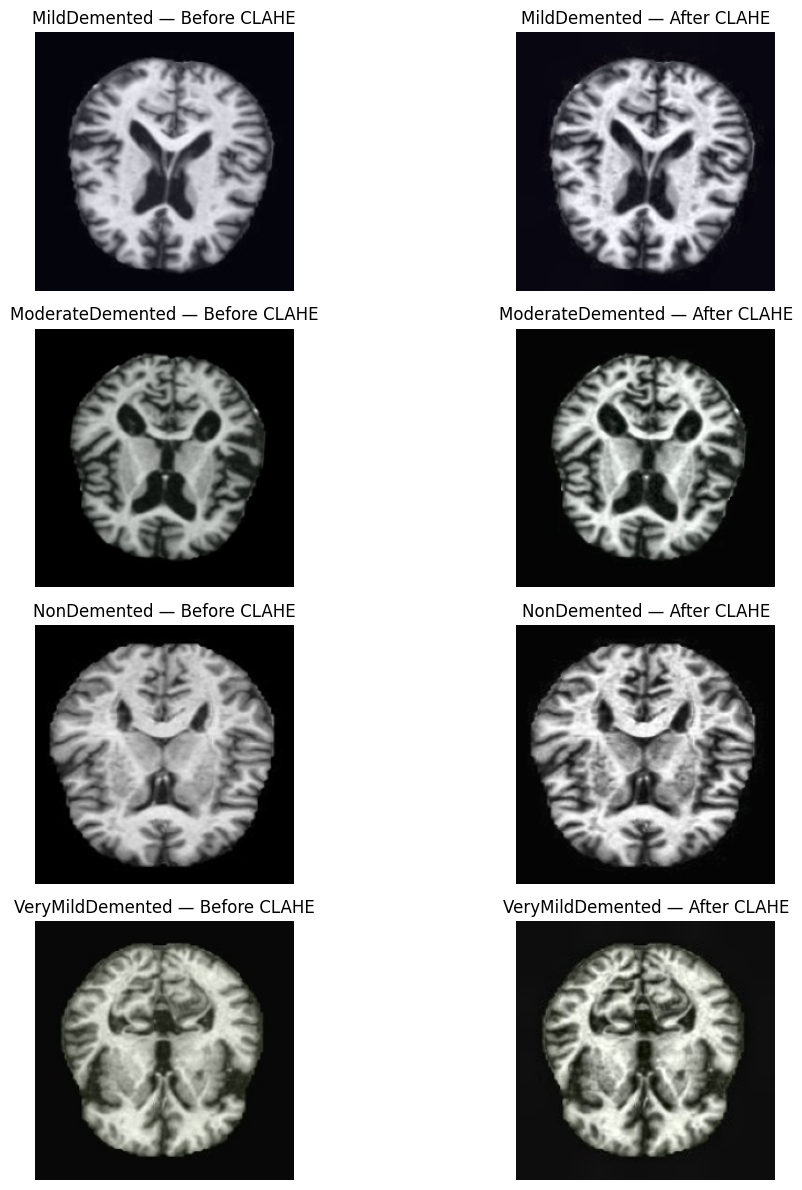

In [ ]:
# === Cell 1 ===
# Setup + count + show before/after enhancement

import os, random, shutil
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


DATA_ROOT = DATA_ROOT = DATA_ROOT


TRAIN_DIR = DATA_ROOT / "train"
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

def list_images(folder: Path):
    return [f for f in os.listdir(folder) if f.lower().endswith(IMG_EXTS)]

def count_split(split_dir: Path):
    counts = {}
    for cls in sorted(os.listdir(split_dir)):
        cpath = split_dir / cls
        if cpath.is_dir():
            counts[cls] = len(list_images(cpath))
    return counts

import cv2

class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.array(img)
        if arr.ndim == 2:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            out = clahe.apply(arr)
            return Image.fromarray(out)
        elif arr.ndim == 3:
            lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
            L, A, B = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            L2 = clahe.apply(L)
            lab2 = cv2.merge((L2, A, B))
            rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
            return Image.fromarray(rgb2)
        return img

enhancer = ApplyCLAHE()

counts_before = count_split(TRAIN_DIR)
print("TRAIN counts (before):")
for k, v in counts_before.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_before.values()))

classes = sorted(list(counts_before.keys()))
n = len(classes)
plt.figure(figsize=(12, 3*n))
for i, cls in enumerate(classes):
    cpath = TRAIN_DIR / cls
    files = list_images(cpath)
    if not files:
        continue
    img_path = cpath / random.choice(files)
    original = Image.open(img_path).convert("RGB")
    # Enhancement -> Resize (224,224)
    before = original.resize((224,224))
    after  = enhancer(before)

    plt.subplot(n, 2, 2*i+1)
    plt.imshow(before)
    plt.title(f"{cls} — Before CLAHE")
    plt.axis("off")

    plt.subplot(n, 2, 2*i+2)
    plt.imshow(after)
    plt.title(f"{cls} — After CLAHE")
    plt.axis("off")

plt.tight_layout()
plt.show()


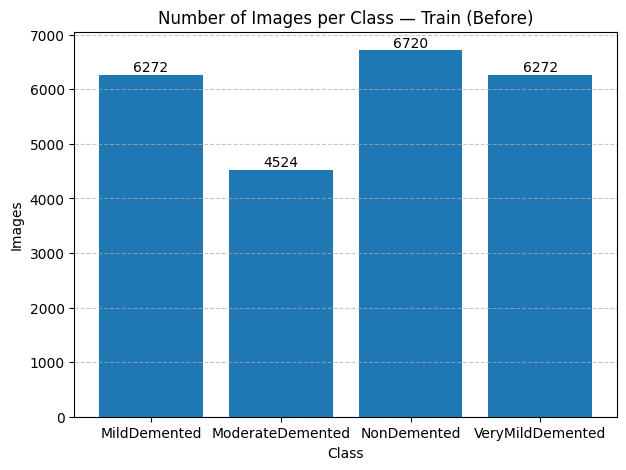

In [ ]:
# === Cell 2 ===
# Bar chart of train counts BEFORE augmentation

import matplotlib.pyplot as plt

classes = list(counts_before.keys())
values  = [counts_before[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (Before)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [ ]:
# === Cell 3 ===
# Build a balanced train set using enhanced images (CLAHE + Resize) for augmentation


from torchvision import transforms
import random

BALANCED_ROOT = Path("./train_balanced")  # الناتج
BALANCED_ROOT.mkdir(parents=True, exist_ok=True)

TARGET_CLASS = "ModerateDemented"
resize_to = (224, 224)

augment = transforms.Compose([
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
])

target_count = max(counts_before.values())
print("Target count for balancing:", target_count)

def symlink_or_copy(src: Path, dst: Path):
    try:
        if dst.exists():
            return
        os.symlink(src, dst)
    except OSError:
        if not dst.exists():
            shutil.copy2(src, dst)

for cls in counts_before.keys():
    src_cls = TRAIN_DIR / cls
    dst_cls = BALANCED_ROOT / cls
    dst_cls.mkdir(exist_ok=True, parents=True)

    files = [f for f in list_images(src_cls)]
    for f in files:
        src = src_cls / f
        dst = dst_cls / f
        symlink_or_copy(src, dst)

src_cls = TRAIN_DIR / TARGET_CLASS
dst_cls = BALANCED_ROOT / TARGET_CLASS
dst_cls.mkdir(exist_ok=True, parents=True)

current_files = [f for f in os.listdir(dst_cls) if f.lower().endswith(IMG_EXTS)]
current_count = len(current_files)

if current_count > target_count:
    keep = set(random.sample(current_files, target_count))
    for f in current_files:
        if f not in keep:
            try:
                os.remove(dst_cls / f)
            except FileNotFoundError:
                pass
    print(f"[Trimmed] {TARGET_CLASS}: kept {target_count}, removed {current_count - target_count}")
    current_count = target_count

elif current_count < target_count:
    base_files = [f for f in list_images(src_cls)]
    i = 0
    while current_count < target_count and base_files:
        f = random.choice(base_files)
        img = Image.open(src_cls / f).convert("RGB")
        # Enhancement -> Resize -> Augmentation
        img_enh = enhancer(img.resize(resize_to))
        img_aug = augment(img_enh)
        out_name = f"aug_{i:06d}.jpg"
        out_path = dst_cls / out_name
        while out_path.exists():
            i += 1
            out_name = f"aug_{i:06d}.jpg"
            out_path = dst_cls / out_name
        img_aug.save(out_path, format="JPEG", quality=95)
        i += 1
        current_count += 1

    print(f"[Augmented] {TARGET_CLASS}: now {current_count} images (target {target_count})")
else:
    print(f"[Balanced] {TARGET_CLASS} already at target: {target_count}")


Target count for balancing: 6720
[Balanced] ModerateDemented already at target: 6720


TRAIN counts (after):
  MildDemented: 6272
  ModerateDemented: 6720
  NonDemented: 6720
  VeryMildDemented: 6272
  Total: 25984


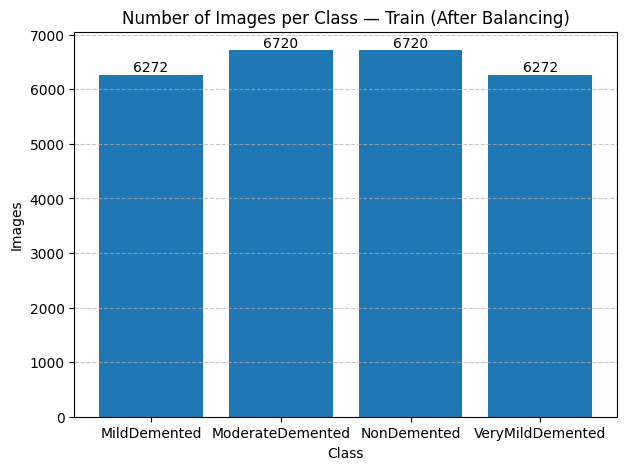

In [ ]:
# === Cell 4 ===
# Count AFTER balancing + final bar chart

def count_split(path: Path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cpath = path / cls
        if cpath.is_dir():
            counts[cls] = len([f for f in os.listdir(cpath) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff"))])
    return counts

counts_after = count_split(BALANCED_ROOT)

print("TRAIN counts (after):")
for k, v in counts_after.items():
    print(f"  {k}: {v}")
print("  Total:", sum(counts_after.values()))


import matplotlib.pyplot as plt

classes = list(counts_after.keys())
values  = [counts_after[c] for c in classes]

plt.figure(figsize=(7,5))
plt.bar(classes, values)
plt.title("Number of Images per Class — Train (After Balancing)")
plt.xlabel("Class")
plt.ylabel("Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.show()


In [ ]:
# === Cell 5 ===

from pathlib import Path
import shutil
from PIL import Image
from tqdm import tqdm

READY_ROOT = Path("./alzheimers_dataset")
(READY_ROOT/"train_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"val_final").mkdir(parents=True, exist_ok=True)
(READY_ROOT/"test_final").mkdir(parents=True, exist_ok=True)

if (READY_ROOT/"train_final").exists():
    shutil.rmtree(READY_ROOT/"train_final")
shutil.copytree(BALANCED_ROOT, READY_ROOT/"train_final")

def prepare_split(src_dir, dst_dir):
    if dst_dir.exists():
        shutil.rmtree(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    for cls in os.listdir(src_dir):
        src_cls = Path(src_dir)/cls
        dst_cls = dst_dir/cls
        dst_cls.mkdir(parents=True, exist_ok=True)
        for f in tqdm(list_images(src_cls), desc=f"Processing {cls}"):
            img = Image.open(src_cls/f).convert("RGB")
            img = enhancer(img.resize((224,224)))
            img.save(dst_cls/f, format="JPEG", quality=95)

prepare_split(DATA_ROOT/"val", READY_ROOT/"val_final")
prepare_split(DATA_ROOT/"test", READY_ROOT/"test_final")

print("alzheimers_dataset")
print(" - train_final (Balanced, Augmented)")
print(" - val_final   (Enhanced only)")
print(" - test_final  (Enhanced only)")



Processing NonDemented: 100%|██████████| 1440/1440 [00:06<00:00, 232.35it/s]

alzheimers_dataset
 - train_final (Balanced, Augmented)
 - val_final   (Enhanced only)
 - test_final  (Enhanced only)


In [ ]:
"""
Lyane's comment

What has been done?

Original dataset: Downloaded the Alzheimer Disease Dataset V2.

Enhancement: Applied CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve brightness/contrast.

Resize: All images were resized to a fixed size of 224×224.

Augmentation: Applied augmentation (Elastic, ColorJitter, Horizontal Flip, Rotation) only to the ModerateDemented class to balance it with the other classes.

Balancing: All classes in the train set now have the same number of images (balanced).

Final splits created:

train_final/ → Enhanced + Augmented (balanced)

val_final/ → Enhanced only (no augmentation)

test_final/ → Enhanced only (no augmentation)

 How to use the dataset?

***********Use only this folder: alzheimers_dataset/********

It contains three subfolders:

train_final

val_final

test_final

"""

"\nLyane's comment\n\nWhat has been done?\n\nOriginal dataset: Downloaded the Alzheimer Disease Dataset V2.\n\nEnhancement: Applied CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve brightness/contrast.\n\nResize: All images were resized to a fixed size of 224×224.\n\nAugmentation: Applied augmentation (Elastic, ColorJitter, Horizontal Flip, Rotation) only to the ModerateDemented class to balance it with the other classes.\n\nBalancing: All classes in the train set now have the same number of images (balanced).\n\nFinal splits created:\n\ntrain_final/ → Enhanced + Augmented (balanced)\n\nval_final/ → Enhanced only (no augmentation)\n\ntest_final/ → Enhanced only (no augmentation)\n\n How to use the dataset?\n\n***********Use only this folder: alzheimers_dataset/********\n\nIt contains three subfolders:\n\ntrain_final\n\nval_final\n\ntest_final\n\n"

## Part 2: Preprocessing

In [ ]:
# ====================================================================
# SECTION 2: Data Preprocessing
# This section defines the transformations and loads the dataset.
# The goal is to prepare the image data to be fed into the model.
# All transformations are applied "on-the-fly" to batches of data.
# ====================================================================

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 2.1 Define the Preprocessing Pipeline
# PyTorch will apply these to every image loaded.
data_transform = transforms.Compose([

    # Resize: Ensures all images have a consistent size for the model.
    # The new size is 224x224 pixels.
    transforms.Resize((224, 224)),

    # Grayscale Conversion: Our MRI images are grayscale, not color.
    # This converts the images to a single channel, which is more
    # memory-efficient and correct for our data.
    transforms.Grayscale(num_output_channels=1),

    # Convert to Tensor: This is the most important step. It converts
    # the image (a set of pixels) into a PyTorch tensor (a numerical array)
    # that the neural network can process. It also scales pixel values to [0, 1].
    transforms.ToTensor(),

    # Transpose dimensions: Move the channel dimension to the last position for Keras compatibility.
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),

    # Normalization: Standardizes the tensor's pixel values.
    # The mean and standard deviation are set for a grayscale image.
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("✅ The data preprocessing pipeline has been successfully defined.")

# 2.2 Load the Dataset
# We use PyTorch's ImageFolder class, which is perfect for our folder structure.
# It automatically reads the images and assigns labels based on the folder names.

# The path to our training data
data_path = 'alzheimers_dataset/train_final/'

# Create a dataset object.
train_dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

# Create a DataLoader. This will load the data in batches and handle
# shuffling and parallel processing, which is critical for training.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"✅ Training dataset loaded. It contains {len(train_dataset)} images.")
print("✅ DataLoader created successfully, ready to deliver batches for training.")

# 2.3 Verification
# We load a single batch to confirm the transformations were applied correctly.
# The printed shape and data type prove that the data is now in the correct format.

# Loading the first batch of images and labels
images, labels = next(iter(train_loader))

# Print the tensor details
print("\n--- Verification of Preprocessed Data ---")
print(f"✔️ Processed tensor shape: {images.shape}")
print(f"✔️ Processed tensor data type: {images.dtype}")
print(f"✔️ Number of classes found: {len(train_dataset.classes)}")
print(f"✔️ Labels in the first batch: {labels}")

✅ The data preprocessing pipeline has been successfully defined.
✅ Training dataset loaded. It contains 25984 images.
✅ DataLoader created successfully, ready to deliver batches for training.

--- Verification of Preprocessed Data ---
✔️ Processed tensor shape: torch.Size([32, 224, 224, 1])
✔️ Processed tensor data type: torch.float32
✔️ Number of classes found: 4
✔️ Labels in the first batch: tensor([0, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 3, 1, 3, 2, 1, 1, 3, 3, 3, 0, 0, 2, 2,
        3, 1, 1, 1, 2, 1, 3, 2])


# build the model

In [ ]:
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Concatenate,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
def Build_model1(input_tensor):
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_tensor) #initiation 2 conv
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x) #capture pivotal information
  # Increase filters and add padding
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) #64 filters to enhance the representation of higher level features
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x) #reduce spatial dimensions while keeping the features
  # Increase filters and add padding
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) #256 to capture the very complicated patterns
  x = Dropout(0.2)(x) # to overcome overfitting
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(128, activation="relu", kernel_initializer='he_normal')(x)
  x = Dense(64, activation="relu")(x)
  output_tensor = Dense(4, activation="softmax")(x)
  return output_tensor

In [ ]:
def Build_model2(input_tensor):
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_tensor) #initiation 2 conv
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)
  x = Dense(64, activation="relu",kernel_initializer='he_normal')(x)
  output_tensor = Dense(4, activation="softmax")(x)
  return output_tensor

In [ ]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

# Define the input tensor
input_tensor = Input(shape=(224, 224, 1))

# Build model1 by calling it with the input tensor
model1_output = Build_model1(input_tensor)

# Build model2 by calling it with the input tensor
model2_output = Build_model2(input_tensor)

# Concatenate the outputs of the two models
concatenated_output = concatenate([model1_output, model2_output])

# Add the final dense layer
output_layer = Dense(4, activation='softmax')(concatenated_output)

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/boot/my/checkpoint.keras'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0.001,monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 50
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=15)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
# Load the validation dataset and create a DataLoader
val_data_path = 'alzheimers_dataset/val_final/'
val_dataset = datasets.ImageFolder(root=val_data_path, transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Shuffle is typically False for validation data

print(f"✅ Validation dataset loaded. It contains {len(val_dataset)} images.")
print("✅ Validation DataLoader created successfully.")

✅ Validation dataset loaded. It contains 5097 images.
✅ Validation DataLoader created successfully.


In [ ]:
model = Model(inputs=input_tensor, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy","AUC","Precision","Recall",])

# Convert PyTorch DataLoaders to TensorFlow compatible data generators
def tf_data_generator(dataloader):
    for images, labels in dataloader:
        # Convert PyTorch tensors to TensorFlow tensors
        images_tf = tf.convert_to_tensor(images.numpy())
        # Apply one-hot encoding to labels
        labels_tf = tf.one_hot(labels.numpy(), depth=4)
        yield images_tf, labels_tf

history = model.fit(tf_data_generator(train_loader),
                    epochs=EPOCHS,
                    validation_data=tf_data_generator(val_loader),
                    steps_per_epoch=len(train_loader),
                    validation_steps=len(val_loader),
                    callbacks=callbacks)

Epoch 1/50
 91/812 ━━━━━━━━━━━━━━━━━━━━ 6:05 507ms/step - AUC: 0.5184 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2572 - loss: 1.4089

KeyboardInterrupt: 

In [ ]:

import matplotlib.pyplot as plt

# Get the history dictionary
history_dict = history.history

# Get the list of epochs
epochs = range(1, len(history_dict['loss']) + 1)

# Define the metrics to plot
metrics_to_plot = ['loss', 'accuracy', 'AUC', 'Precision', 'Recall']

# Create a figure to hold the plots
plt.figure(figsize=(20, 10))

for i, metric in enumerate(metrics_to_plot):
    train_metric = history_dict[metric]
    val_metric = history_dict[f'val_{metric}'] # Validation metrics have 'val_' prefix

    plt.subplot(2, 3, i + 1) # Create subplots in a 2x3 grid
    plt.plot(epochs, train_metric, 'bo', label=f'Training {metric.capitalize()}')
    plt.plot(epochs, val_metric, 'b', label=f'Validation {metric.capitalize()}')
    plt.title(f'Training and validation {metric.lower()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()


experment with patience value to see which one works the best

In [ ]:
import matplotlib.pyplot as plt

# Get the history dictionaries for each model
histories = [history for model, history in list_of_models]

# Define the metrics to plot
metrics_to_plot = ['loss', 'accuracy', 'AUC', 'Precision', 'Recall']

# Create separate plots for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    plt.title(f'{metric.capitalize()} vs. Epochs for Different Patience Values')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.grid(True)

    for i, history in enumerate(histories):
        history_dict = history.history
        epochs = range(1, len(history_dict['loss']) + 1)
        patience = patience_values[i]

        # Plot training metric
        plt.plot(epochs, history_dict[metric], marker='o', linestyle='--', label=f'Train {metric.capitalize()} (Patience {patience})')

        # Plot validation metric
        val_metric = history_dict[f'val_{metric}']
        plt.plot(epochs, val_metric, marker='x', linestyle='-', label=f'Val {metric.capitalize()} (Patience {patience})')

    plt.legend()
    plt.show()

##upload the model